<a href="https://colab.research.google.com/github/Rohan5076/AIMLOPS/blob/main/Anil_M2_NB_MiniProject_1_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini Project: Face Mask Detection using Convolutional Neural Networks

## Learning Objectives

At the end of the experiment, you will be able to :

* load the image dataset using ImageDataGenerator from the path directory
* perform data augmentation on the fly and create  batches of the dataset
* build the convolutional neural networks for classification problem
* visualize & interpret what CNN layers learn
* use the transfer learning (pre-trained models) for classification problems

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool.
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/dataset-images-with-mask.jpg)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1059 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people are not correctly wearing their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset
  
- Without Mask/ With Mask/ Partial Mask
  
Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


## Grading = 10 Points

### Import Required packages

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import PIL
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow import keras
import glob, os

# Part-A [5-Marks]

### Analyzing the shape and distribution of datasets [1 Mark]

Store the list of the paths from the training dataset for images of partial-mask, with_mask, and without_mask in variables partial, on, and off respectively. Hint : [Check the 'glob' section.](https://realpython.com/working-with-files-in-python/)

In [ ]:
partial_folder = "/content/MP2_FaceMask_Dataset/train/partial_mask"
on_folder = "/content/MP2_FaceMask_Dataset/train/with_mask"
off_folder = "/content/MP2_FaceMask_Dataset/train/without_mask"

partial = glob.glob(partial_folder + "/*.*")
on = glob.glob(on_folder + "/*.*")
off = glob.glob(off_folder + "/*.*")

Store paths of all three types of images in one variable. Check and store the height and width of each image.

Hint: Use PIL(PIL.Image.open) library to open the image from the path, convert it into a NumPy array and check for shape.  

In [ ]:
all_paths = partial + on + off

In [ ]:
heights = []
widths = []
for path in all_paths:
  img = PIL.Image.open(path)
  img_array = np.array(img)
  height, width, _ = img_array.shape
  heights.append(height)
  widths.append(width)

Discuss the distribution of images. Calculate and display max, min and average of height and width of all images.

In [ ]:
max_height = max(heights)
min_height = min(heights)
avg_height = sum(heights) / len(heights)

max_width = max(widths)
min_width = min(widths)
avg_width = sum(widths) / len(widths)

print("Height:")
print(f"Maximum height: {max_height}")
print(f"Minimum height: {min_height}")
print(f"Average height: {avg_height:.2f}")

print("\nWidth:")
print(f"Maximum width: {max_width}")
print(f"Minimum width: {min_width}")
print(f"Average width: {avg_width:.2f}")

Height:
Maximum height: 4608
Minimum height: 141
Average height: 449.38

Width:
Maximum width: 3456
Minimum width: 110
Average width: 434.44


### Visualize the sample images of each class before augmentation [1 Mark]

In [ ]:
def plot_sample_images(paths, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)

    for i in range(5):
        img_path = paths[i]
        img = PIL.Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

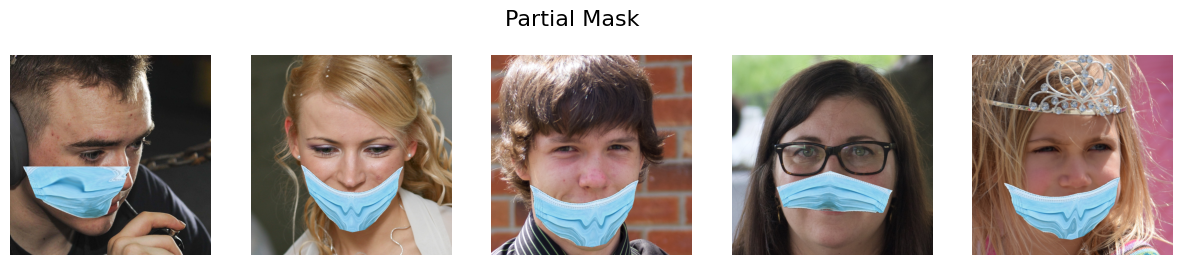

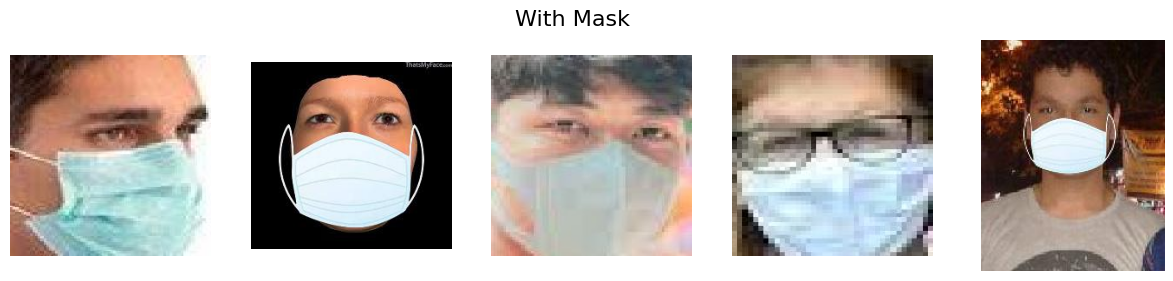

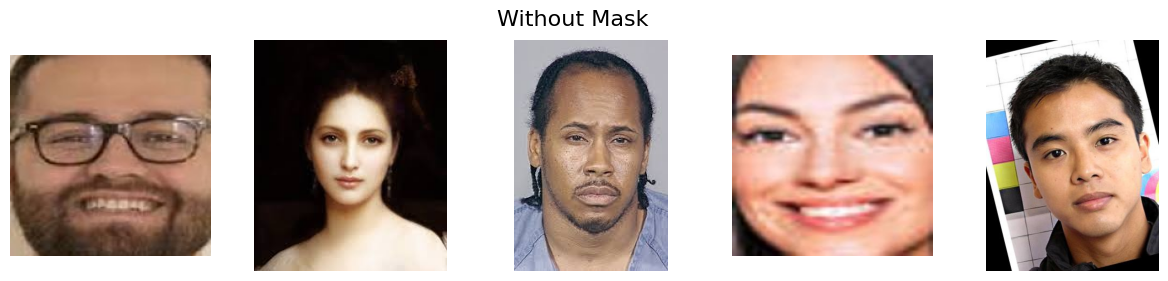

In [ ]:
plot_sample_images(partial, "Partial Mask")
plot_sample_images(on, "With Mask")
plot_sample_images(off, "Without Mask")

### Load the images using ImageDataGenerator [1 Mark]

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [ ]:
'''train_datagen = ImageDataGenerator(
    rescale=1./255,            # rescale pixel values to [0, 1]
    rotation_range=20,         # randomly rotate images by 20 degrees
    width_shift_range=0.2,     # randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,    # randomly shift images vertically by 20% of the height
    shear_range=0.2,           # apply shear transformation with intensity of 0.2
    zoom_range=0.2,            # randomly zoom into images by 20%
    horizontal_flip=True,      # randomly flip images horizontally
    fill_mode='nearest'        # strategy for filling in newly created pixels
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
'''


"train_datagen = ImageDataGenerator(\n    rescale=1./255,            # rescale pixel values to [0, 1]\n    rotation_range=20,         # randomly rotate images by 20 degrees\n    width_shift_range=0.2,     # randomly shift images horizontally by 20% of the width\n    height_shift_range=0.2,    # randomly shift images vertically by 20% of the height\n    shear_range=0.2,           # apply shear transformation with intensity of 0.2\n    zoom_range=0.2,            # randomly zoom into images by 20%\n    horizontal_flip=True,      # randomly flip images horizontally\n    fill_mode='nearest'        # strategy for filling in newly created pixels\n)\n\nval_test_datagen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = train_datagen.flow_from_directory(\n    TRAINING_DIR,\n    target_size=(224, 224),\n    batch_size=32,\n    class_mode='binary'\n)\n\nvalidation_generator = val_test_datagen.flow_from_directory(\n    VALIDATION_DIR,\n    target_size=(224, 224),\n    batch_size=32,\n    cl

In [ ]:
img_height, img_width = 224 , 224
batch_size = 32
nb_epochs = 10

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data


Found 4025 images belonging to 3 classes.
Found 1004 images belonging to 3 classes.


Check class indices

In [ ]:
print("Class indices for train generator:", train_generator.class_indices)
print("Class indices for validation generator:", validation_generator.class_indices)

Class indices for train generator: {'partial_mask': 0, 'with_mask': 1, 'without_mask': 2}
Class indices for validation generator: {'partial_mask': 0, 'with_mask': 1, 'without_mask': 2}


Check the shape of the image from train_generator

In [ ]:
image_shape = train_generator.image_shape

In [ ]:
print("Shape of the images from train_generator:", image_shape)

Shape of the images from train_generator: (224, 224, 3)


### Visualize a few sample images using data generator [1 Mark]

In [ ]:
def plot_images(generator, num_images=5):
    # Get a batch of images and labels
    x_batch, y_batch = next(generator)

    # Plot the images
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x_batch[i])
        plt.title('Class: {}'.format('Mask' if y_batch[i] == 1 else 'No Mask'))
        plt.axis('off')
    plt.show()


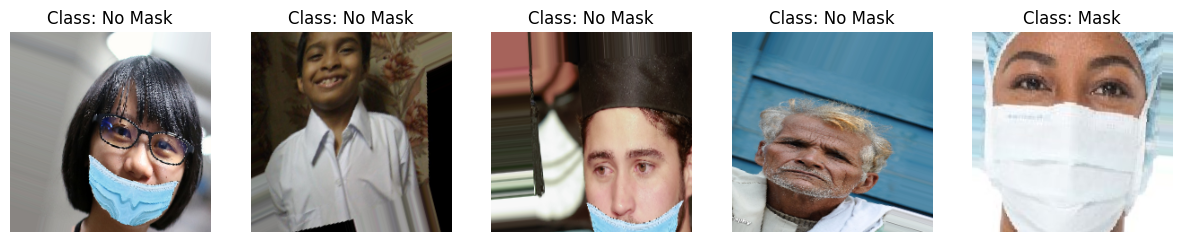

In [ ]:
plot_images(train_generator)

## Build the CNN model using Keras [1 Mark]



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**  

Passing an image with input shape of 3-D and to calculate the output:

 $O = \frac{n - f + 2p}{s} + 1$

 where

 $n$ = image dimension

 $f$ = filter size

 $p$ = padding

 $s$ = stride

**MaxPool**

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of:

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is:

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

**model 1 with 2 convolutional (feature representation) and 2 maxpool layers (down sampling) and 2 dense layers for classification.**

In [ ]:
input_shape = (224, 224, 3)
# Define the model architecture
model1 = Sequential([
    Conv2D(100, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(100, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(3, activation='softmax')
])

In [ ]:
'''model1.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs)'''

In [ ]:
# YOUR CODE HERE
#Note: Applying a convolution to an image will make it smaller (if no padding).
#Convolving a 3x3 filter over images means we’ll lose a single pixel on all sides (2 in total).
#In the given case, sliding a 3x3 filter over a 224x224 image results in a 222x222 image
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Fit the data to the model

In [ ]:
epochs = 10

history = model1.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)


Epoch 1/10
126/126 [==============================] - 75s 587ms/step - loss: 0.4466 - accuracy: 0.8763 - val_loss: 0.2552 - val_accuracy: 0.9243
Epoch 2/10
126/126 [==============================] - 72s 568ms/step - loss: 0.1966 - accuracy: 0.9424 - val_loss: 0.3013 - val_accuracy: 0.9183
Epoch 3/10
126/126 [==============================] - 71s 560ms/step - loss: 0.1623 - accuracy: 0.9528 - val_loss: 0.2739 - val_accuracy: 0.9094
Epoch 4/10
126/126 [==============================] - 72s 572ms/step - loss: 0.1318 - accuracy: 0.9627 - val_loss: 0.2451 - val_accuracy: 0.9273
Epoch 5/10
126/126 [==============================] - 71s 563ms/step - loss: 0.1136 - accuracy: 0.9665 - val_loss: 0.2183 - val_accuracy: 0.9363
Epoch 6/10
126/126 [==============================] - 70s 552ms/step - loss: 0.1115 - accuracy: 0.9662 - val_loss: 0.1829 - val_accuracy: 0.9432
Epoch 7/10
126/126 [==============================] - 79s 626ms/step - loss: 0.1001 - accuracy: 0.9707 - val_loss: 0.2055 - val_ac

Plot training and validation loss

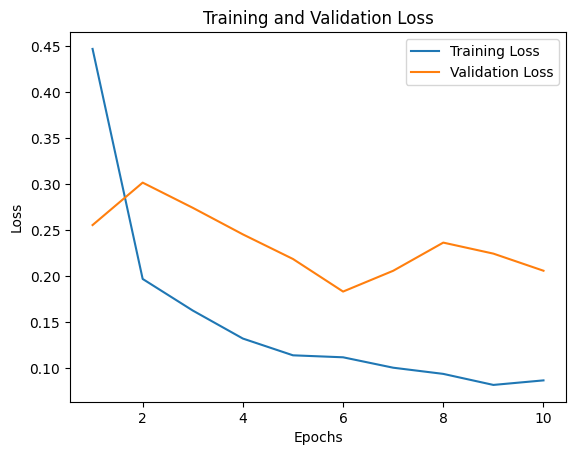

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation loss
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


**model 2 with few more conv layers**

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Define callback list
* Fit the model and evaluate the model

Define the model

In [ ]:
input_shape = (224, 224, 3)
# Define the model architecture
model2 = Sequential([
    Conv2D(100, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(100, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(100, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(100, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(3, activation='softmax')
])


Compile the model

In [ ]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Define Callbacks

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

Fit the data to the model

In [ ]:
epochs = 10
history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
126/126 [==============================] - 81s 630ms/step - loss: 0.3510 - accuracy: 0.8614 - val_loss: 0.2311 - val_accuracy: 0.9143
Epoch 2/10
126/126 [==============================] - 79s 627ms/step - loss: 0.1707 - accuracy: 0.9424 - val_loss: 0.2834 - val_accuracy: 0.9133
Epoch 3/10
126/126 [==============================] - 72s 573ms/step - loss: 0.1430 - accuracy: 0.9570 - val_loss: 0.1248 - val_accuracy: 0.9631
Epoch 4/10
126/126 [==============================] - 71s 566ms/step - loss: 0.1125 - accuracy: 0.9677 - val_loss: 0.0960 - val_accuracy: 0.9671
Epoch 5/10
126/126 [==============================] - 72s 575ms/step - loss: 0.1192 - accuracy: 0.9630 - val_loss: 0.1866 - val_accuracy: 0.9363
Epoch 6/10
106/126 [========================>.....] - ETA: 9s - loss: 0.1083 - accuracy: 0.9728

Plot training and validation loss

range(1, 8)


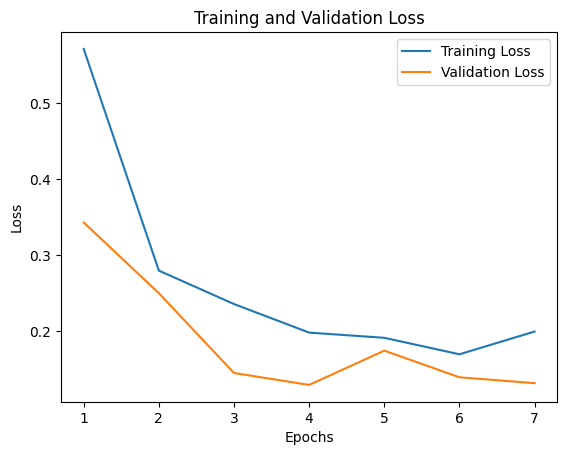

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation loss
epochs_range = range(1, 7 + 1)
print(epochs_range)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Prediction on a random test image

In [ ]:
test_loss, test_acc = model2.evaluate(validation_generator)

40/40 [==============================] - 5s 114ms/step - loss: 0.1289 - accuracy: 0.9658


1/1 [==============================] - 0s 17ms/step


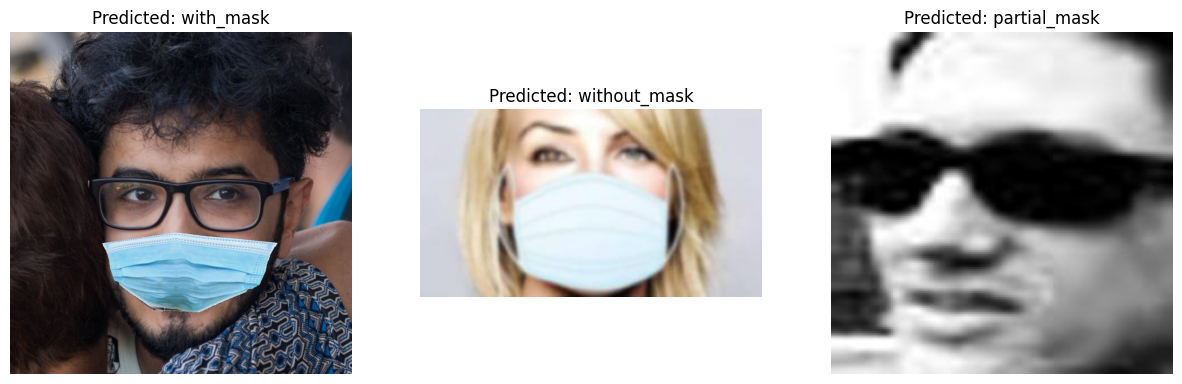

In [ ]:
from keras.preprocessing import image
import random
# Function to load and preprocess a random image from a given folder
def load_random_image(folder_path):
    image_paths = glob.glob(folder_path + "/*.jpg")
    random_image_path = random.choice(image_paths)
    img = image.load_img(random_image_path, target_size=(224, 224))  # Adjust target_size if needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Normalize pixel values
    return img_array, random_image_path


partial_folder = "/content/MP2_FaceMask_Dataset/test/partial_mask"
on_folder = "/content/MP2_FaceMask_Dataset/test/with_mask"
off_folder = "/content/MP2_FaceMask_Dataset/test/without_mask"

# Load one random image from each category
partial_img_array, partial_img_path = load_random_image(partial_folder)
on_img_array, on_img_path = load_random_image(on_folder)
off_img_array, off_img_path = load_random_image(off_folder)

# Make predictions on each image
predictions_partial = model2.predict(partial_img_array)
predictions_on = model2.predict(on_img_array)
predictions_off = model2.predict(off_img_array)

# Interpret the prediction results
class_labels = ['with_mask', 'without_mask', 'partial_mask']
predicted_class_index_partial = np.argmax(predictions_partial)
predicted_class_label_partial = class_labels[predicted_class_index_partial]

predicted_class_index_on = np.argmax(predictions_on)
predicted_class_label_on = class_labels[predicted_class_index_on]

predicted_class_index_off = np.argmax(predictions_off)
predicted_class_label_off = class_labels[predicted_class_index_off]

# Display the images and predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Partial Mask
axes[0].imshow(image.load_img(partial_img_path))
axes[0].set_title(f'Predicted: {predicted_class_label_partial}')
axes[0].axis('off')

# With Mask
axes[1].imshow(image.load_img(on_img_path))
axes[1].set_title(f'Predicted: {predicted_class_label_on}')
axes[1].axis('off')

# Without Mask
axes[2].imshow(image.load_img(off_img_path))
axes[2].set_title(f'Predicted: {predicted_class_label_off}')
axes[2].axis('off')

plt.show()

# Part-B [5-Marks]

## Visualization [2 Marks]

Define a function 'get_img_array' that takes two parameters image path and target size. It returns the converted image to array.

Display this image.

Hint:: Consider AST3 for visualization.

In [ ]:
# YOUR CODE HERE

## Instantiating a model that returns "layer activations"

Hint:: Use 'keras.model' to define this model.

In [ ]:
# Instantiating a model that returns "layer activations"
# YOUR CODE HERE

Once the activation model is defined, predict the image tensor created using this model.

In [ ]:
# Compute layer activations
# YOUR CODE HERE

## Visualize first feature map

In [ ]:
# Visualise activation

# YOUR CODE HERE

## Visualize feature map after each layer

In [ ]:
# YOUR CODE HERE

Successive feature maps are of smaller dimensions but scaled to be the same size during visualization.

## Visualise all the feature maps of all the layers

In [ ]:
# Post-processing code - only visualizaton
# Visualizing every channel in every intermediate activation
# YOUR CODE HERE
# YOUR CODE HERE

# ConvNet Filters [1 Mark]

## Print the names of  conv and MaxPooling layers.

Hint:: 'model2.layer'

In [ ]:
# YOUR CODE HERE

## Create a feature extractor model

In [ ]:
# YOUR CODE HERE
# Check the model summary
# YOUR CODE HERE

## Use the feature extractor model to extract feature out of the image tensor.

In [ ]:
# YOUR CODE HERE

Define a function 'compute_loss' it takes two arguments, image and filter index. It returns the filter activation using 'tf.reduce_mean'.

In [ ]:
# YOUR CODE HERE

## Loss maximization via stochastic gradient ascent.
Define a function to implement this step.

In [ ]:
@tf.function
# YOUR CODE HERE

## Define a function to generate filter visualizations

This function uses gradient ascent to generate an image that maximizes the activation of a given filter in a CNN.

In [ ]:
# YOUR CODE HERE

## Define a function to convert a tensor into a valid image

In [ ]:
# YOUR CODE HERE

Generate a list of images, where each image in the list represents the activation pattern of a particular filter in the given layer.

In [ ]:
# Post processing- Just visualization
# Generating a grid of all filter response patterns in a layer

# YOUR CODE HERE

Stitch together all the images in the 'all_images' list and save the resulting image as a PNG file. The resulting image shows a grid of all the filter activation patterns in the given layer.

In [ ]:
# YOUR CODE HERE

Display the images

In [ ]:
# YOUR CODE HERE

All the steps discussed in visualization section can be easily understood from AST3.

## Transfer Learning [2 Marks]

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://drive.google.com/file/d/1d5WSWQmdVYYcJhvhMcZMoK5-BPOC1B_7/view?usp=sharing)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

#### VGG16

Define the pre-trained vgg model with dense layers.

Display the model summary

In [ ]:
# YOUR CODE HERE

In [ ]:
# Compile the model
# YOUR CODE HERE

Fit the data to the model

In [ ]:
# YOUR CODE HERE

Plot training and validation loss

In [ ]:
# YOUR CODE HERE

#### ResNet50

Define the pre-trained resnet model with dense layers

In [ ]:
# YOUR CODE HERE

Fit the data to the model

In [ ]:
# YOUR CODE HERE

Plot the validation and training loss

In [ ]:
# YOUR CODE HERE

### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:**
* Convert the image to numpy array and resize to the shape which model accept.
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

In [ ]:
# Make a prediction using model that is created by making use of transer learning technique
# YOUR CODE HERE

### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- What process was followed to tune the hyperparameters?